<a href="https://colab.research.google.com/github/jbmmbj/m494/blob/main/MNIST_toy_8_modes_4_12_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


"Toy Data: 8-Modes Mixture Model"

Source of original code: https://github.com/vislearn/analyzing_inverse_problems/blob/master/toy_8-modes/toy_8-modes.ipynb

# **FIXED & adapted to MNIST data**




The code has been fixed to accomodate outdated versions of dependencies. Of note is the FrEIA module ReversibleGraphNet, which was modified by the developers to output a tuple of the transformed variable and the log Jacobian determinant. (The developers later depreciated ReversibleGraphNet in favor of GraphINN.) ReversibleGraphNet still works in this model, but the code had to be modified to ignore the variable assignment of the log Jacobian determinant output.

Additionally, there was an error in the optimization step. Some of the model parameters are NaN (NoneType) which prevents backpropagation. Relatively few of the model parameters have this problem, so the code was modified to simply ignore these parameters. This issue may be related to the fix mentioned above regarding the log Jacobian determinant. However, the log Jacobian determinant is not a trainable parameter. Nonetheless, the original model trains and outputs as expected with these changes made.

-----------------------------------------

The code has been changed to model MNIST data. These changes include pre/post processing of MNIST data, updated names and dimensions of variables, deletion of code to plot during training, and an increased number of iterations per epoch.

## Introduction

**Text from cited authors (may not be accurate):**

"This notebook is supposed to demonstrate how to use FrEIA to create reversible architectures.

We will use the toy data from the paper in this example."

In [ ]:
pip install FrEIA

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
%matplotlib inline
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, InvertibleSigmoid, AllInOneBlock


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Setting up the data

**Text from cited authors (may not be accurate):**

"We generate the data by sampling from a Gaussian mixture distribution with 8 labeled modes. The dataset will contain $2^{20}$ samples, $10000$ of which we will use for testing purposes.

You can see a plot of the test data below.

In the forward process our model is supposed to predict the label (or in this case, color) of a sample based on its position in $\mathbb{R}^2$. In the reverse direction the model should allow us to sample from the mixture component given by a label."

In [ ]:
batch_size = 1200
test_split = 10000

Load MNIST data

In [ ]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train_t = torch.tensor(x_train)
x_train_flat = torch.flatten(x_train_t, 1, 2)
x_train_flat = x_train_flat / 255
x_test_t = torch.tensor(x_test)
x_test_flat = torch.flatten(x_test_t, 1, 2)
x_test_flat = x_test_flat / 255

One-hot encode labels

In [ ]:
y_train_t = torch.tensor(y_train)
y_test_t = torch.tensor(y_test)

zero = torch.tensor([1,0,0,0,0,0,0,0,0,0])
one = torch.tensor([0,1,0,0,0,0,0,0,0,0])
two = torch.tensor([0,0,1,0,0,0,0,0,0,0])
three = torch.tensor([0,0,0,1,0,0,0,0,0,0])
four = torch.tensor([0,0,0,0,1,0,0,0,0,0])
five = torch.tensor([0,0,0,0,0,1,0,0,0,0])
six = torch.tensor([0,0,0,0,0,0,1,0,0,0])
seven = torch.tensor([0,0,0,0,0,0,0,1,0,0])
eight = torch.tensor([0,0,0,0,0,0,0,0,1,0])
nine = torch.tensor([0,0,0,0,0,0,0,0,0,1])

In [ ]:
y_train_empty = torch.empty(60000, 10)

for i in range(len(y_train_t)):
  if y_train_t[i] == 0:
    y_train_empty[i] = zero
  elif y_train_t[i] == 1:
    y_train_empty[i] = one
  elif y_train_t[i] == 2:
    y_train_empty[i] = two
  elif y_train_t[i] == 3:
    y_train_empty[i] = three
  elif y_train_t[i] == 4:
    y_train_empty[i] = four
  elif y_train_t[i] == 5:
    y_train_empty[i] = five
  elif y_train_t[i] == 6:
    y_train_empty[i] = six
  elif y_train_t[i] == 7:
    y_train_empty[i] = seven
  elif y_train_t[i] == 8:
    y_train_empty[i] = eight
  elif y_train_t[i] == 9:
    y_train_empty[i] = nine

y_train_1hot = y_train_empty

In [ ]:
y_test_empty = torch.empty(10000, 10)

for i in range(len(y_test_t)):
  if y_test_t[i] == 0:
    y_test_empty[i] = zero
  elif y_test_t[i] == 1:
    y_test_empty[i] = one
  elif y_test_t[i] == 2:
    y_test_empty[i] = two
  elif y_test_t[i] == 3:
    y_test_empty[i] = three
  elif y_test_t[i] == 4:
    y_test_empty[i] = four
  elif y_test_t[i] == 5:
    y_test_empty[i] = five
  elif y_test_t[i] == 6:
    y_test_empty[i] = six
  elif y_test_t[i] == 7:
    y_test_empty[i] = seven
  elif y_test_t[i] == 8:
    y_test_empty[i] = eight
  elif y_test_t[i] == 9:
    y_test_empty[i] = nine

y_test_1hot = y_test_empty

## Setting up the model

**Text from cited authors (may not be accurate):**

"Our model consists of three invertible blocks using multiplicative coupling layers and 3-layer fully connected sub-networks for $s_i$ and $t_i$. The input is encoded in 2 dimensions. The latent dimension $z$ is set to 2 and concatenated with the predicted labels $y$ encoded as a 8-dimensional one-hot vector. In- and output are zero-padded to 16 dimensions."

In [ ]:
ndim_tot = 800
ndim_x = 784
ndim_y = 10
ndim_z = 784

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

## Training the model

**Text from cited authors (may not be accurate):**

"We will train our model using 3 losses. In the forward direction we apply a MSE loss to the assigned label and a distributional loss to the latent variable $z$.
We make use of the reversability of our model and apply a third loss, that matches the distribution of samples from our dataset to the distribution of backward predictions of our model.
You can find more information on the losses in the [paper](https://arxiv.org/abs/1808.04730)."

In [ ]:
# Training parameters
n_epochs = 50
n_its_per_epoch = 50
batch_size = 1200

lr = 1e-3
l2_reg = 2e-5

y_noise_scale = 1e-1
zeros_noise_scale = 5e-2

# relative weighting of losses:
lambd_predict = 3.
lambd_latent = 300.
lambd_rev = 400.

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_flat, y_test_1hot),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_flat, y_train_1hot),
    batch_size=batch_size, shuffle=True, drop_last=True)


**Text from cited authors (may not be accurate):**

"We can now define our training method. Note how we simply used the model for forward training, zeroed the gradients and switch to backwards training simply by setting `rev=True`. Randomness in the samples generated by backwards prediction is achieved by drawing $z$ randomly from a 2-dimensional Normal distribution."

In [ ]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0

    t_start = time()

    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.
    loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch*5) / n_epochs)))

    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))


        optimizer.zero_grad()

        # Forward step:

        output, _ = model(x)

        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           y), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)

        output_rev, _ = model(y_rev, rev=True)
        output_rev_rand, _ = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_predict * loss_fit(output_rev, x)

        l_tot += l_rev.data.item()

        l_rev.backward()

        for p in model.parameters():
            if p.grad is not None:
              p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return l_tot / batch_idx


**Text from cited authors (may not be accurate):**

"We initialize our model parameters using normal distributions. The following loop over epochs plots label predictions and backwards predicted samples, so you can see the model getting better during training."

In [ ]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)

model.to(device)

N_samp = 200

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z),
                     y_samps], dim=1)
y_samps = y_samps.to(device)

try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x, _ = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()

        pred_num, _ = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device))
        pred_num = pred_num.data[:, -10:].argmax(dim=1)



except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

100%|###########################################| 50/50 [06:21<00:00,  7.62s/it]



Training took 6.35 minutes



In [ ]:
pred_num

tensor([9, 1, 5, 3, 7, 7, 1, 4, 5, 9, 0, 8, 2, 9, 3, 8, 4, 6, 6, 6, 9, 7, 5, 4,
        6, 9, 0, 5, 7, 2, 5, 8, 0, 6, 0, 8, 2, 5, 3, 7, 3, 9, 9, 0, 3, 2, 0, 9,
        1, 3, 1, 8, 9, 2, 1, 9, 7, 4, 8, 4, 3, 4, 8, 0, 7, 8, 0, 4, 3, 2, 4, 2,
        3, 4, 7, 7, 5, 6, 8, 0, 9, 0, 7, 1, 5, 8, 0, 0, 2, 8, 6, 4, 1, 9, 8, 7,
        4, 9, 3, 8, 1, 2, 0, 7, 2, 3, 6, 7, 6, 2, 0, 0, 0, 3, 1, 8, 1, 7, 9, 9,
        4, 1, 4, 0, 8, 1, 6, 3, 4, 9, 2, 2, 4, 4, 7, 7, 5, 5, 3, 6, 0, 8, 4, 7,
        8, 2, 4, 3, 0, 1, 6, 8, 4, 4, 1, 9, 9, 7, 4, 8, 3, 2, 2, 6, 8, 2, 2, 9,
        5, 6, 6, 5, 2, 1, 9, 1, 0, 0, 5, 1, 9, 4, 0, 8, 3, 3, 4, 5, 4, 3, 6, 0,
        0, 1, 3, 7, 7, 8, 9, 4], device='cuda:0')

In [ ]:
x_samps_unflat = torch.unflatten(x_samps, 1, (28,28))

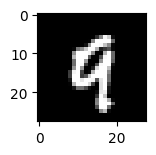

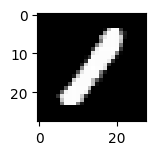

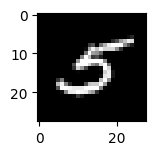

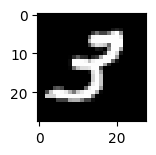

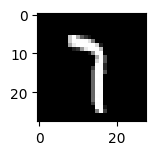

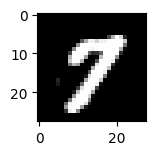

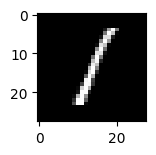

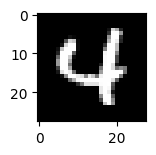

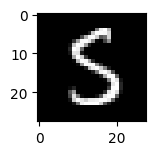

In [ ]:
from matplotlib import pyplot

for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_samps_unflat[i].numpy(), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:
max(rev_x[1])

5.102012

In [ ]:
min(rev_x[1])

-23.24313

In [ ]:
def normalize(values, actual_bounds, desired_bounds):
    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

In [ ]:
import numpy

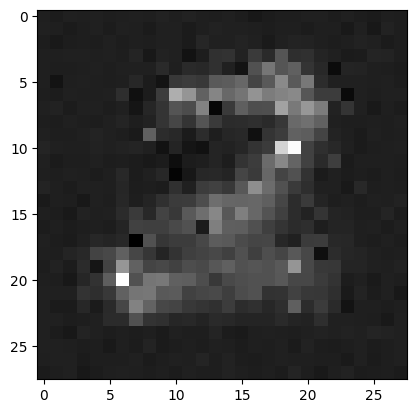

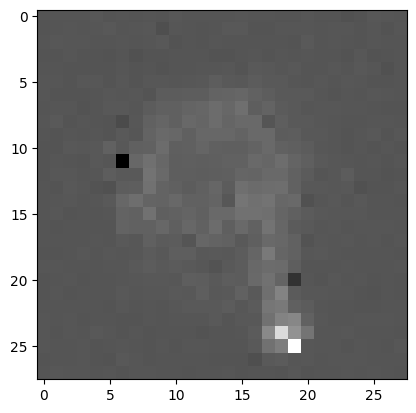

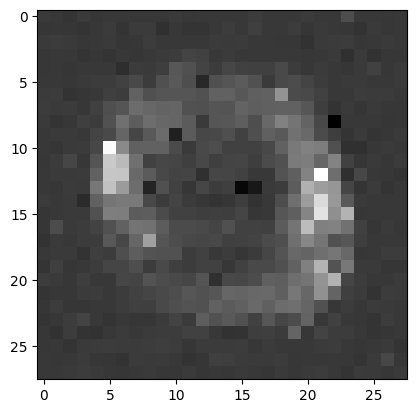

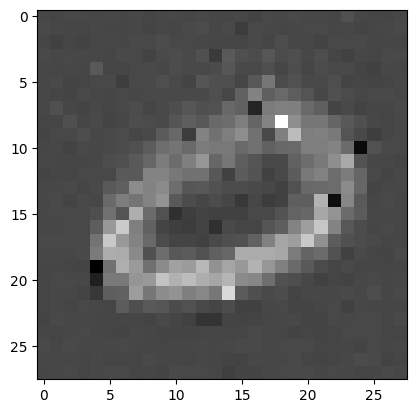

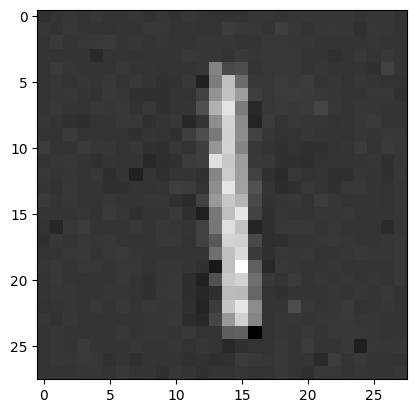

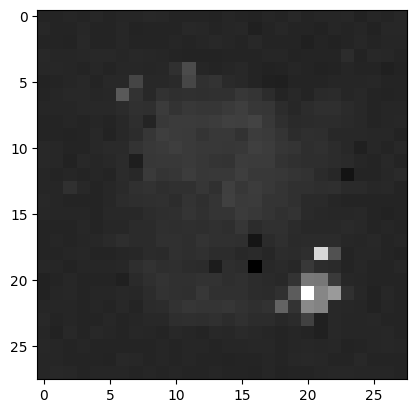

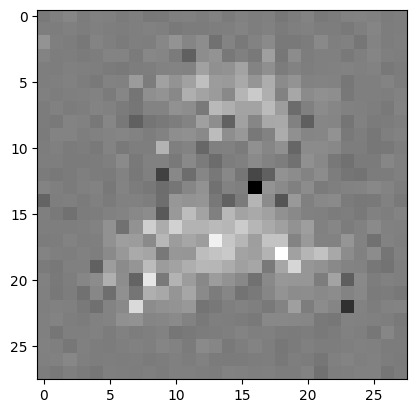

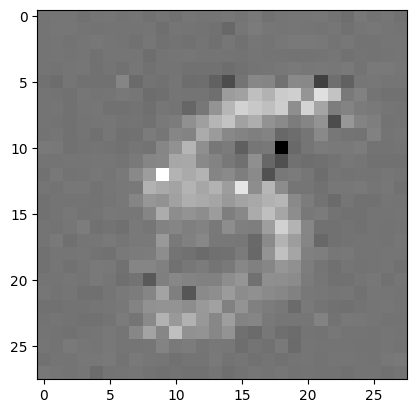

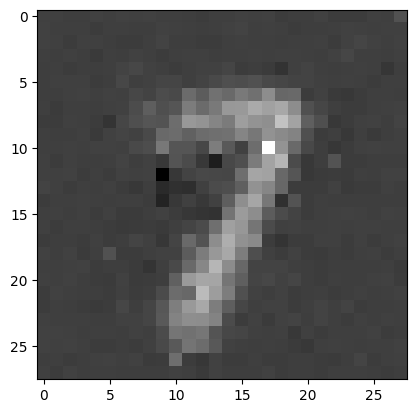

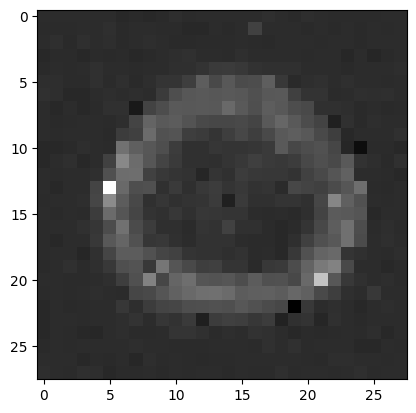

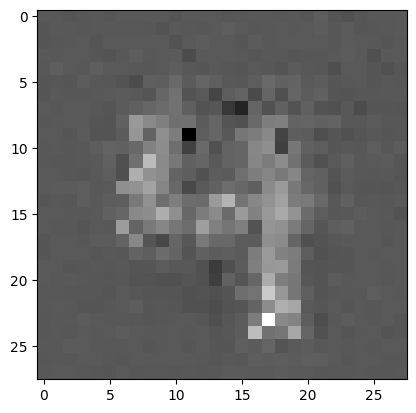

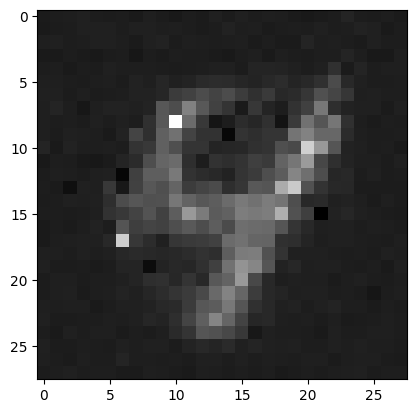

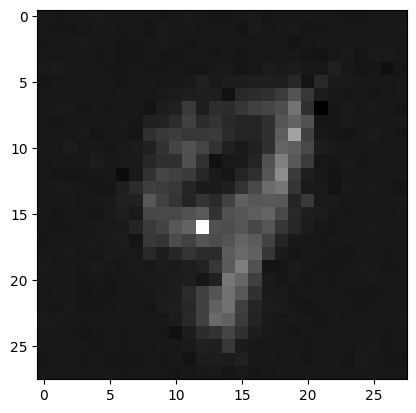

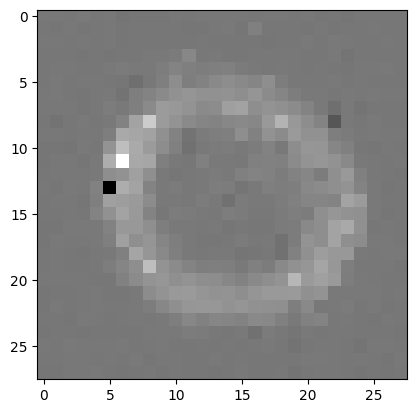

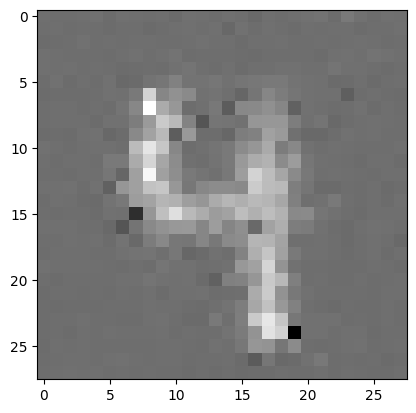

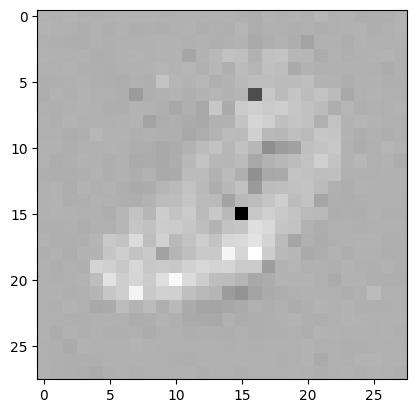

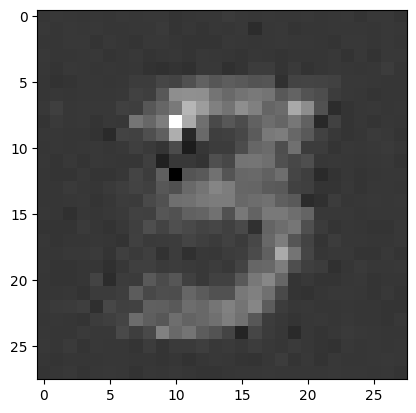

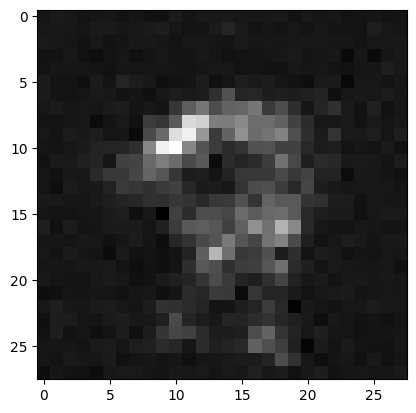

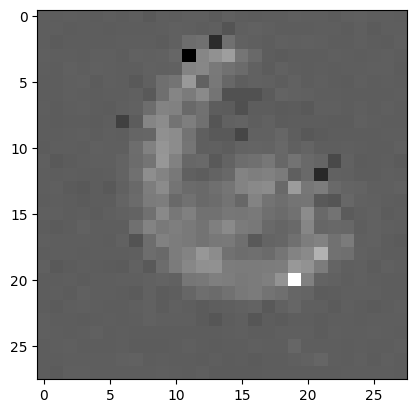

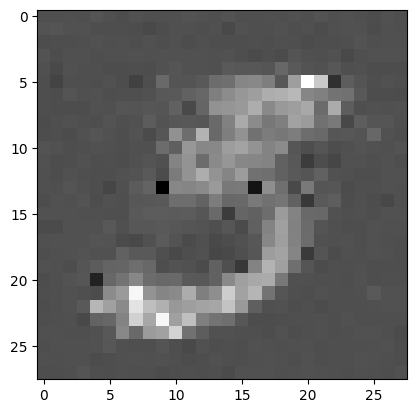

In [ ]:
for p in range(20):

  norm_x = normalize(
      (255*rev_x[p]),
      (min(rev_x[p]),max(rev_x[p])),
      (0,255)
  )

  norm_x1 = numpy.trunc(norm_x)
  test2 = norm_x1[0:784]
  test3 = numpy.reshape(test2, (28,28))

  pyplot.imshow(test3, cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:
for p in range (20):
  print(torch.argmax(y_samps[p, -10:]).item())

2
9
0
0
1
2
2
5
7
0
4
4
4
0
4
2
3
7
6
3
